# <center>Обучение с учителем. Методы классификации
## <center>Практика. Дерево решений в задаче предсказания выживания пассажиров "Титаника". Решение

In [0]:
from google.colab import drive
drive.mount('/content/drive')
#подключаем гугл диск

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.ensemble import BaggingClassifier


**Считываем обучающую и тестовую выборки.**

In [0]:
train_df = pd.read_csv("/content/drive/My Drive/DZ10/titanic_train.csv") 
test_df = pd.read_csv("/content/drive/My Drive/DZ10/titanic_test.csv") 

In [0]:
s = train_df['Survived']
full_df=pd.concat([test_df, train_df], sort=False)

In [0]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [0]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Simonius-Blumer, Col. Oberst Alfons",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [0]:
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kreuchen, Miss. Emilie",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


**Заполним пропуски медианными значениями.**

In [0]:
full_df['Age'].fillna(full_df['Age'].median(), inplace=True)
full_df['Cabin'].fillna(full_df['Cabin'].mode()[0], inplace=True) #значение которое появляеться чаще всего.
full_df['Embarked'].fillna(full_df['Embarked'].mode()[0], inplace=True) #значение которое появляеться чаще всего.  
full_df['Fare'].fillna(full_df['Fare'].median(), inplace=True)

Давайте попробуем ввести новые признаки.

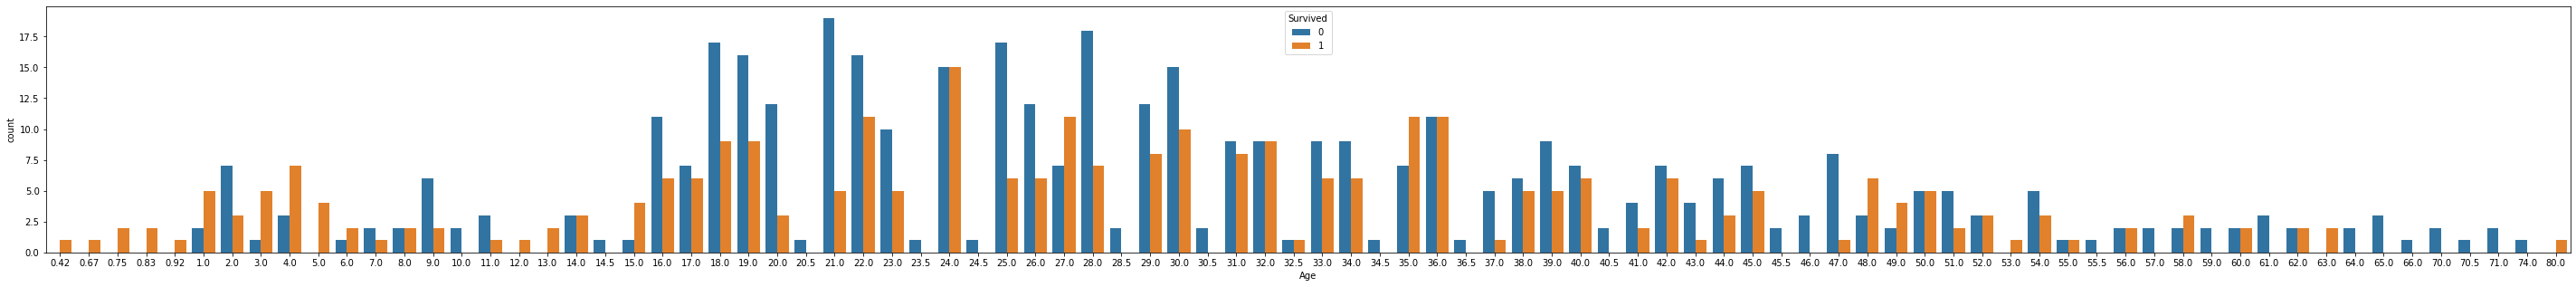

In [0]:
import seaborn as sns
plt.figure(figsize=(50,5))
sns.countplot(train_df['Age'],hue=train_df['Survived'],linewidth=25);
#граифк возраста и выживания.

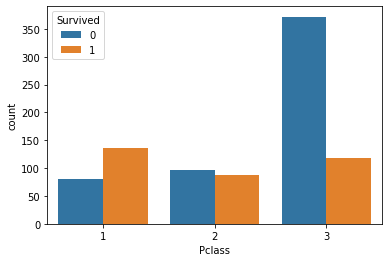

In [0]:
sns.countplot(train_df['Pclass'],hue=train_df['Survived']); #как видим в 3м классе выживших меньше всего

In [0]:
full_df['Pclass_count']=full_df.groupby('Pclass')['Pclass'].transform('count') #вводим новую переменную


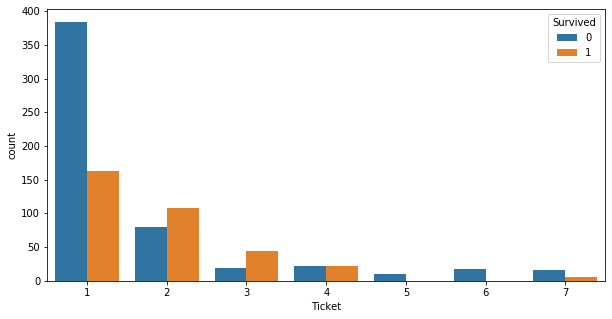

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(train_df.groupby('Ticket')['Ticket'].transform('count'),hue=train_df['Survived']);


In [0]:
full_df['Ticket_count']=full_df.groupby('Ticket')['Ticket'].transform('count')


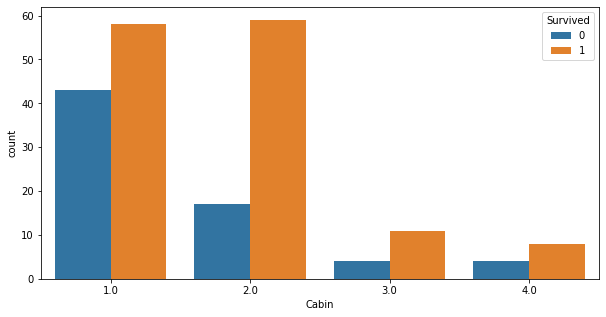

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(train_df.groupby('Cabin')['Cabin'].transform('count'),hue=train_df['Survived']);

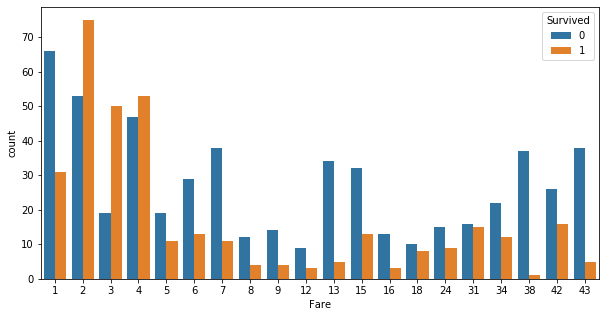

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(train_df.groupby('Fare')['Fare'].transform('count'),hue=train_df['Survived']);



In [0]:
def cu(train_df):
  for j in ['Fare','Age']:
    cut_points = [np.percentile(train_df[j], i) for i in [10,30,50, 80,95]]
    s=j+'new'
    train_df[s] = 1
    for i in range(3):
      train_df[s] = train_df[s] + (train_df[j] < cut_points[i])
  return train_df
#вводим новую переменную которая являеться разбиением на диапозон 'Fare','Age'

In [0]:
full_df=cu(full_df)

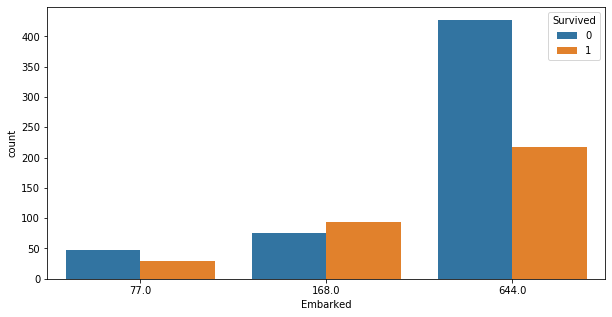

In [0]:
plt.figure(figsize=(10,5))
sns.countplot(train_df.groupby('Embarked')['Embarked'].transform('count'),hue=train_df['Survived']);

In [0]:
full_df['Embarked_count']=full_df.groupby('Embarked')['Embarked'].transform('count')


**Кодируем категориальные признаки `Pclass`, `Sex`, `SibSp`, `Parch` и `Embarked` с помощью техники One-Hot-Encoding.**

In [0]:
full_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived', 'Pclass_count',
       'Ticket_count', 'Farenew', 'Agenew', 'Embarked_count'],
      dtype='object')

In [0]:
full_df = pd.concat([full_df, pd.get_dummies(full_df['Pclass'], 
                                               prefix="PClass"),
                     pd.get_dummies(full_df['Sex'], prefix="Sex"),
                     pd.get_dummies(full_df['Cabin'], prefix="Cabin"),
                     pd.get_dummies(full_df['SibSp'], prefix="SibSp"),
                     pd.get_dummies(full_df['Parch'], prefix="Parch"),
                     pd.get_dummies(full_df['Embarked'], prefix="Embarked"),
                     pd.get_dummies(full_df['Ticket'], prefix="Ticket"),
                     pd.get_dummies(full_df['Fare'], prefix="Fare"),
                     pd.get_dummies(full_df['Agenew'], prefix="Agenew"),
                     pd.get_dummies(full_df['Farenew'], prefix="Farenew"),
                     pd.get_dummies(full_df['Pclass_count'], prefix="Pclass_count"),
                     pd.get_dummies(full_df['Ticket_count'], prefix="Ticket_count"),
                     pd.get_dummies(full_df['Embarked_count'], prefix="Embarked_count"),
                  
                      ],
                     axis=1)


In [0]:
test_df_s=full_df[full_df['Survived'].isna()==True]
train_df_s=full_df[full_df['Survived'].isna()==False]
#Разделяем обратно выборки


In [0]:
print('test_df_s-', test_df_s.shape,'\ntrain_df_s - ',train_df_s.shape)

test_df_s- (418, 1459) 
train_df_s -  (891, 1459)


**В тестовой выборке появляется новое значение Parch = 9, которого нет в обучающей выборке. Проигнорируем его.**<br>
У меня не где нечего не появилось так как я изначально объединял выборки при предобработке

In [0]:
train_df_s.shape, test_df_s.shape

((891, 1459), (418, 1459))

In [0]:
y=train_df_s['Survived']
train_df_s.drop('Survived',axis=1,inplace=True)
test_df_s.drop('Survived',axis=1,inplace=True)
train_df_s.drop(train_df_s.select_dtypes(include = ['object']),axis=1,inplace=True)
test_df_s.drop(test_df_s.select_dtypes(include = ['object']),axis=1,inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
y=y.astype(int)

In [0]:
#train_df.drop('Ticket_count_6', axis=1, inplace=True)

In [0]:
train_df_s.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Pclass_count,Ticket_count,Farenew,Agenew,Embarked_count,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,Cabin_A18,Cabin_A19,Cabin_A20,Cabin_A21,Cabin_A23,Cabin_A24,Cabin_A26,Cabin_A29,Cabin_A31,Cabin_A32,Cabin_A34,Cabin_A36,Cabin_A5,Cabin_A6,Cabin_A7,Cabin_A9,Cabin_B10,Cabin_B101,Cabin_B102,Cabin_B11,...,Fare_120.0,Fare_133.65,Fare_134.5,Fare_135.6333,Fare_136.7792,Fare_146.5208,Fare_151.55,Fare_153.4625,Fare_164.8667,Fare_211.3375,Fare_211.5,Fare_221.7792,Fare_227.525,Fare_247.5208,Fare_262.375,Fare_263.0,Fare_512.3292,Agenew_1,Agenew_2,Agenew_3,Agenew_4,Farenew_1,Farenew_2,Farenew_3,Farenew_4,Pclass_count_277,Pclass_count_323,Pclass_count_709,Ticket_count_1,Ticket_count_2,Ticket_count_3,Ticket_count_4,Ticket_count_5,Ticket_count_6,Ticket_count_7,Ticket_count_8,Ticket_count_11,Embarked_count_123,Embarked_count_270,Embarked_count_916
0,1,3,22.0,1,0,7.2500,709,1,4,3,916,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
1,2,1,38.0,1,0,71.2833,323,2,1,1,270,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
2,3,3,26.0,0,0,7.9250,709,1,3,2,916,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
3,4,1,35.0,1,0,53.1000,323,2,1,1,916,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
4,5,3,35.0,0,0,8.0500,709,1,2,1,916,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1


## 1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 2. Используйте параметр `random_state=17` для воспроизводимости результатов.**

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(random_state=17)


**Сделайте с помощью полученной модели прогноз для тестовой выборки **

In [0]:
from sklearn.model_selection import cross_val_score
print('Прогноз-  ', cross_val_score(clf, train_df_s,y, cv=10).mean())
clf.fit(train_df_s,y)

Прогноз-   0.8036079900124845


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

**Отобразите дерево с помощью `export_graphviz` и `dot`.**

In [0]:
from sklearn.tree import export_graphviz
s=export_graphviz(clf, out_file='tree.dot') #


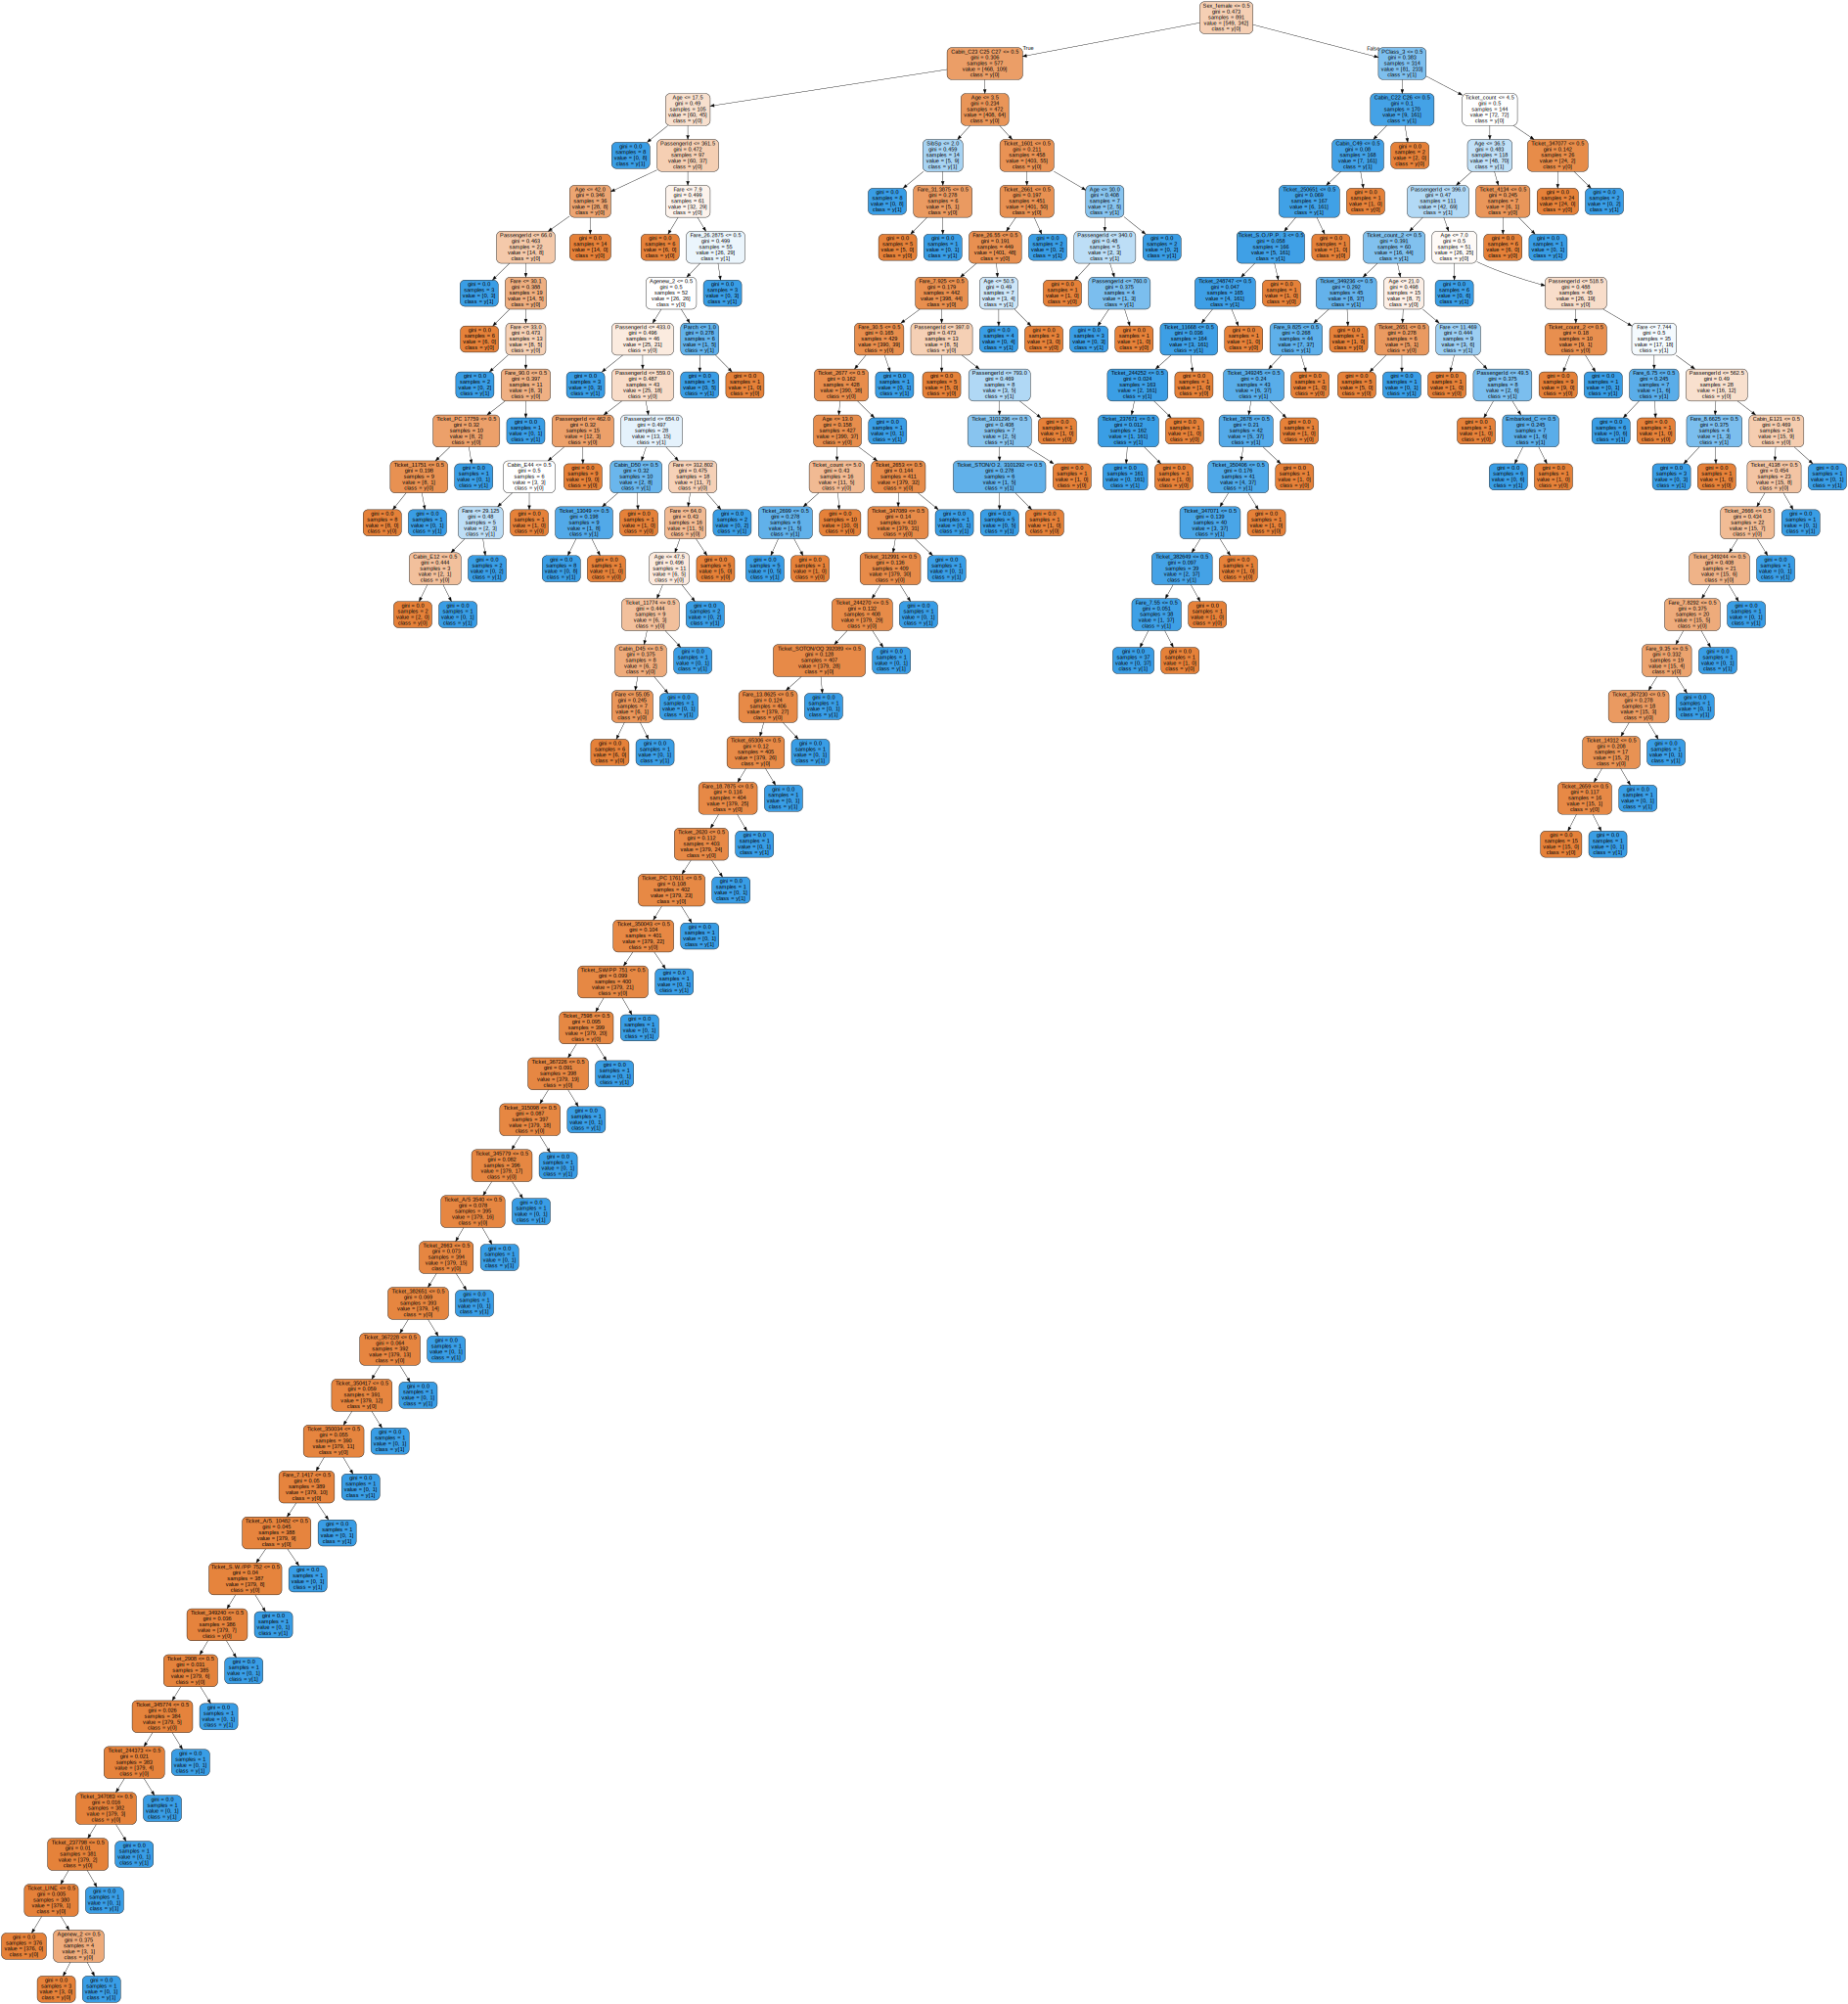

In [0]:
import graphviz 

dot_data = export_graphviz(clf, out_file=None, 
                                feature_names = train_df_s.columns, class_names = True,
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data) 
graph

## 2. Дерево решений с настройкой параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`). Также укажите `random_state=17`. Максимальную глубину и минимальное число элементов в листе настройте на 5-кратной кросс-валидации с помощью `GridSearchCV`.**

In [0]:
clf=DecisionTreeClassifier(random_state=17)
tree_params = {'max_depth': list(range(5, 15)), 
               'min_samples_leaf': list(range(1, 5))}

grid = GridSearchCV(clf, tree_params,cv=5).fit(train_df_s,y)


<font color='red'>Вопрос 3. </font> Каковы лучшие параметры дерева, настроенные на кросс-валидации с помощью `GridSearchCV`?

In [0]:
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

<font color='red'>Вопрос 4. </font> Какой получилась средняя доля верных ответов на кросс-валидации для дерева решений с лучшим сочетанием гиперпараметров `max_depth` и `min_samples_leaf`?

In [0]:
cross_val_score(grid, train_df_s,y, cv=10).mean()

0.8047440699126094

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [0]:
predict=grid.predict(test_df_s)

#predict=clf_sklern.predict(test_df)
#predict=model.predict(test_df)
test_df_s['Survived']=y
#test_df_s['Survived'].fillna(0, inplace=True)


**Сформируйте файл посылки и отправьте на Kaggle.**

In [0]:
new_df=test_df_s[['PassengerId','Survived']]

In [0]:
new_df.to_csv('ex.csv',index=False)

In [0]:
new_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


<font color='red'>Вопрос 5. </font> Каков результат второй посылки (дерево решений с настройкой гиперпараметров) в публичном рейтинге соревнования Titanic?

0.79/ 4000 место. 

---



---

In [0]:

X_train, X_test, y_train, y_test = train_test_split(train_df_s,y, test_size=0.3)

In [0]:
def tune_xgb_tree(features, targets):
    parameter_grid = {
                 'max_depth' : [7, 8, 9],
                 'max_delta_step': [1],
                 'n_estimators': [20, 40, 60, 80],
                 'colsample_bylevel': [0.8, 0.9, 1.0],
                 'colsample_bytree': [0.6, 0.8, 1.0],
                 'subsample': [0.3, 0.4, 0.5, 0.6],
                 }
    xgb_model = XGBClassifier()
    print(xgb_model.get_params().keys())

    grid_search = GridSearchCV(xgb_model,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=3,
                               n_jobs=2,
                               verbose=1)

    grid_search.fit(features, targets)
    model = grid_search.best_estimator_
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best estimator: {}'.format(grid_search.best_estimator_))
    
    return model, parameters

In [0]:
model, params=tune_xgb_tree(X_train,y_train)

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])
Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   24.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 14.2min
[Parallel(n_jobs=2)]: Done 1296 out of 1296 | elapsed: 15.0min finished


Best score: 0.8330701102440233
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3, verbosity=1)


In [0]:
model.score(X_test,y_test)
#Результат на валидационной будет хуже.

0.8208955223880597

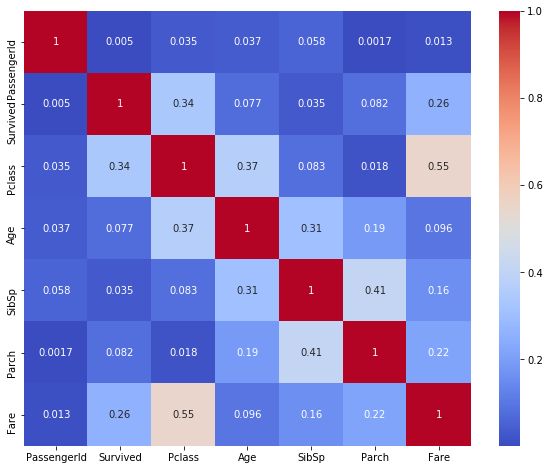

In [0]:
new_train_df = pd.read_csv("/content/drive/My Drive/DZ10/titanic_train.csv") 
corr_matrix = new_train_df.corr().abs()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [0]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df_s,y, test_size=0.3)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_df_s,y, test_size=0.3)
clf3 = BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best'),
                         n_estimators=20).fit(X_train,y_train)

print('DecisionTreeClassifier: [%.8f]' % accuracy_score(y_test, clf3.predict(X_test)))

DecisionTreeClassifier: [0.83582090]


In [0]:
y=clf3.predict(test_df_s)

##Выводы:
1. Дальнейшее улучшение параметров возможно только путем погружения в тему (например ввести параметр на какой палубе была каюта и так далее)
2. Обработку параметров лучше проводить совместно.
3. В целом простые методы показывают лучший результат в данной задаче. 